包括内容：统计包，pdf/cdf，t-test,单元/多元回归

In [1]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

这一章主要讲的是两种做回归的方法。各有千秋。用到了scipy.stats包和statsmodels.api，分别对应linregress方程和OLS方程。是一个统计方程包。

In [2]:
import scipy.stats as stats
import statsmodels.api as sm

C:\Users\unax9\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


stats还有一个功能是产生一个分布。

In [3]:
mu=0
std=1
p=stats.norm(mu,std)
p                     #p为一个分布变量，可以直接计算该分布下的一些值

0.241970724519


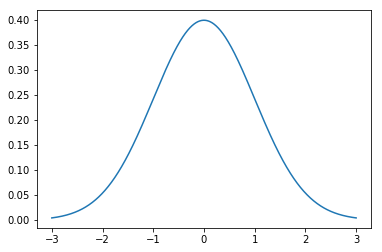

In [4]:
#计算标准分布下的pdf
grid=np.linspace(mu-3*std,mu+3*std,1000) #产生1000个范围在均值左右三倍标准差范围内的数
plt.plot(grid, p.pdf(grid))
print(p.pdf(1))

0.841344746069
1 sigma interval: 0.6827
95% confidence interval: 0.95
99% confidence interval: 0.99


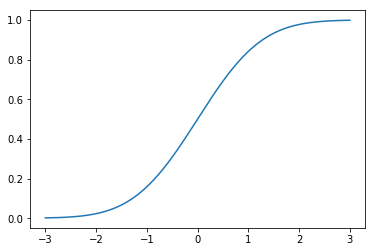

In [5]:
#计算标准分布下的cdf
grid=np.linspace(mu-3*std,mu+3*std,1000) 
plt.plot(grid, p.cdf(grid))
print(p.cdf(1))
print("1 sigma interval: " + str( round(p.cdf(1)-p.cdf(-1),4) ) )
print("95% confidence interval: " + str( round(p.cdf(1.96)-p.cdf(-1.96),4) ) )
print("99% confidence interval: " + str( round(p.cdf(2.575)-p.cdf(-2.575),4) ) )

In [6]:
url="https://www.dropbox.com/s/9346pp2iu5prv8s/MonthlyFactors.csv?dl=1" 
Data = pd.read_csv(url, index_col=0,na_values=-99)
Data.head()

,RF,MKT,SMB,HML,Mom
Date,,,,,
7/31/1926,0.22,3.18,-2.30,-2.87,NaN
8/31/1926,0.25,2.89,-1.40,4.19,NaN
9/30/1926,0.23,0.59,-1.32,0.01,NaN
10/31/1926,0.32,-2.92,0.04,0.51,NaN
11/30/1926,0.31,2.84,-0.20,-0.35,NaN


假设我们要做MKT Premium 和SMB的关系，第一步求MKT Premium：

In [7]:
Data['Pre']=Data['MKT']-Data['RF']  #第一种方法直接新建列并用market rate减rf
Data.head()

,RF,MKT,SMB,HML,Mom,Pre
Date,,,,,,
7/31/1926,0.22,3.18,-2.30,-2.87,NaN,2.96
8/31/1926,0.25,2.89,-1.40,4.19,NaN,2.64
9/30/1926,0.23,0.59,-1.32,0.01,NaN,0.36
10/31/1926,0.32,-2.92,0.04,0.51,NaN,-3.24
11/30/1926,0.31,2.84,-0.20,-0.35,NaN,2.53


In [8]:
Test=Data.iloc[:,1:4].subtract(Data['RF'],axis=0) #第二种方法用subtract方程运算，可以通过修改axis修改成行减行。
Test.head()

,MKT,SMB,HML
Date,,,
7/31/1926,2.96,-2.52,-3.09
8/31/1926,2.64,-1.65,3.94
9/30/1926,0.36,-1.55,-0.22
10/31/1926,-3.24,-0.28,0.19
11/30/1926,2.53,-0.51,-0.66


In [9]:
(Data.iloc[:,1:2]-Data['RF']).head()   
#第一种方法不能多列同时操作，且不能换相减方向。第二种方法需要新建立Dataframe或覆盖原数据，但是有axis参数会比较灵活

,1/31/1927,1/31/1928,1/31/1929,1/31/1930,1/31/1931,1/31/1932,1/31/1933,1/31/1934,1/31/1935,1/31/1936,...,9/30/2008,9/30/2009,9/30/2010,9/30/2011,9/30/2012,9/30/2013,9/30/2014,9/30/2015,9/30/2016,MKT
Date,,,,,,,,,,,,,,,,,,,,,
7/31/1926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8/31/1926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9/30/1926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10/31/1926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
11/30/1926,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


回归分析，第一种方法，用scipy.stats的linregress方程。这个方程的优势在于简单，因为会直接返回所有常用的值，缺点就是，这是方程仅适用于单元回归。  
必须输入五个变量让方程返回，五个变量随便命名，第一个为斜率，即系数，第二个为截距，第三个为R值而不是R方，第四个为系数p_value，第五个为系数标准误差。  
方程自变量里面，第一个是x，第二个是y。

In [10]:
slope,intercept,r_value,p_value,std_err=stats.linregress(Data.Pre,Data.SMB)

In [11]:
#系数
print(slope)
print(np.cov(Data.Pre, Data.SMB)[0][1]/Data.Pre.var())  #[0][1]是因为np.cov()返回的是矩阵，我们只要右上角的cov而不要var

0.190654490204
0.190654490204


In [12]:
#截距
print(intercept)
print(Data.SMB.mean()-slope*Data.Pre.mean())

0.0848754934935
0.0848754934935


In [13]:
#R方
r_value**2

0.10141084258677421

In [14]:
#系数显著性
t=slope/std_err
print(t)
print(p_value)
print(1-p.cdf(t))                       #用上面的标准正态分布

df=Data.shape[0]-2
print(1-stats.t.cdf(t,df))

11.0911060405
3.69376661703e-27
0.0
0.0


多元回归只能用statsmodels.api的OLS方程。构造方法是这样。
一般我们写多元回归的式子是：
$$\hat{y}=k_0+k_1*x_1+k_2*x_2+...$$
我们将这个式子改写成：
$$\hat{y}=k_0*1+k_1*x_1+k_2*x_2+...$$
这样就变成了$y$对$x=[1,x_1,x_2,...]$这些变量做回归。

接下来，我们尝试做RF对MKT,SMB,HML三个变量的回归。

In [15]:
#首先，我们先获得数据[x_1,x_2]
x=Data.iloc[:,1:4]
x.head()

,MKT,SMB,HML
Date,,,
7/31/1926,3.18,-2.30,-2.87
8/31/1926,2.89,-1.40,4.19
9/30/1926,0.59,-1.32,0.01
10/31/1926,-2.92,0.04,0.51
11/30/1926,2.84,-0.20,-0.35


In [16]:
#然后我们增加常数项列
x=sm.add_constant(x)
x.head()

,const,MKT,SMB,HML
Date,,,,
7/31/1926,1.0,3.18,-2.30,-2.87
8/31/1926,1.0,2.89,-1.40,4.19
9/30/1926,1.0,0.59,-1.32,0.01
10/31/1926,1.0,-2.92,0.04,0.51
11/30/1926,1.0,2.84,-0.20,-0.35


In [17]:
#再获得y，开始做回归
y=Data['RF']
results = sm.OLS(y,x, missing='drop') #格式是y在前，x在后，记得同样要用一个变量记录返回值

#missing = 'drop' 是用于去掉空值NaN的

In [18]:
print(results)
print(results.fit())
results.fit().summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     RF   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.001
Method:                 Least Squares   F-statistic:                     1.247
Date:                Mon, 30 Oct 2017   Prob (F-statistic):              0.291
Time:                        18:37:33   Log-Likelihood:                -53.207
No. Observations:                1092   AIC:                             114.4
Df Residuals:                    1088   BIC:                             134.4
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.2770      0.008     35.338      0.000       0.262       0.292
MKT           -0.0004      0.002     -0.262      0.793      -0.003       0.003
SMB           -0.0041      0.003     -1.628      0.104      -0.009       0.001
HML            0.0021      0.002      0.942      0.347      -0.002       0.007
==============================================================================
Omnibus:                      175.373   Durbin-Watson:                   0.052
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              277.603
Skew:                           1.067   Prob(JB):                     5.24e-61
Kurtosis:                       4.245   Cond. No.                         5.79
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [19]:
#调出系数
results.fit().params

const    0.276975
MKT     -0.000408
SMB     -0.004129
HML      0.002139
dtype: float64

In [20]:
#调出std_err
results.fit().bse

const    0.007838
MKT      0.001556
SMB      0.002537
HML      0.002271
dtype: float64

In [21]:
#调出t-value 和 p-value
print(results.fit().tvalues)
print(results.fit().pvalues)

const    35.337627
MKT      -0.261894
SMB      -1.627824
HML       0.941730
dtype: float64
const    8.327568e-183
MKT       7.934524e-01
SMB       1.038517e-01
HML       3.465397e-01
dtype: float64


In [22]:
#调出f-value 和 p-value
print(results.fit().fvalue)
print(results.fit().f_pvalue)

1.2474861029
0.291210086625


In [23]:
#调出R方
results.fit().rsquared

0.0034279680891898812

In [24]:
#具体还能调出什么来，下面自己一个个去试，并与上面大表对比就可以了
dir(results.fit())

['HC0_se',
 'HC1_se',
 'HC2_se',
 'HC3_se',
 '_HCCM',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_cache',
 '_data_attr',
 '_get_robustcov_results',
 '_is_nested',
 '_wexog_singular_values',
 'aic',
 'bic',
 'bse',
 'centered_tss',
 'compare_f_test',
 'compare_lm_test',
 'compare_lr_test',
 'condition_number',
 'conf_int',
 'conf_int_el',
 'cov_HC0',
 'cov_HC1',
 'cov_HC2',
 'cov_HC3',
 'cov_kwds',
 'cov_params',
 'cov_type',
 'df_model',
 'df_resid',
 'eigenvals',
 'el_test',
 'ess',
 'f_pvalue',
 'f_test',
 'fittedvalues',
 'fvalue',
 'get_influence',
 'get_prediction',
 'get_robustcov_results',
 'initialize',
 'k_constant',
 'llf',
 'load',
 'model',
 'mse_mode